# Wetland water depth analyses <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment
* **Products used:** 

* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sys
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, shape, mapping
import rasterio.features
import rasterio.mask
import datacube
from datacube.utils import geometry
import scipy.signal, scipy.ndimage
from affine import Affine

from pysheds.grid import Grid

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours

%load_ext autoreload
%autoreload 2

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Wetland_volumes')

<a id='analysisparams'></a>
### Analysis parameters

The following parameters will need to be set prior to running this notebook:

#### LiDAR parameters
* `LiDARtifFile`: A string pointing to the location of the lidar file to read in for the analysis. Note that this code currently assumes that this is a geotiff file.
* `accumulation_threshold`: e.g. 10000. This value determines how many LiDAR grid cells need to drain into a cell for it to be considered a drainage (for the purposes of calculating heigh above nearest drainage). See discussion [here](#HAND) for more details. 
* `flatness_threshold`: e.g. 0. How much variability in the LiDAR DEM we are considering to be 'flat'. This is in the same units as the LiDAR DEM. This allows for some small variance to still be considered a uniform flat surface. This parameter is used for detecting water in the LiDAR scene.
* `count_threshold`: e.g. 1500. If a number appears in the LiDAR DEM more than `count_threshold` times, then it is considered in the final array. This allows us to only look for large, flat areas, like water. We choose to set this to 1500, which equates to half of the area of the smallest waterbody identified in DEA Waterbodies, or 2.4 Landsat 25m pixels.
#### Vegetation shapefile parameters
* `VegShapeFile`: A string pointing to the location of the vegetation communities file to read in for the analysis. Note that this code currently assumes that this is a shape file.
* `VegShapeFileVegNameColumn`: A name string pointing to the column/attribute in the shapefile that contains the vegetation community names. This column will be used to group polygons within the shapefile that belong to the same vegetation community, and to generate labels for vegetation types being mapped.
* `VegShapeFileVegNameUIDColumn`: A name string pointing to the column/attribute in the shapefile that contains a numerical ID that corresponds to the vegetation community names. This numerical ID is used in place of the `VegShapeFileVegNameColumn` to burn into the shapefile when it is converted from a shapefile to a raster. This then alows us to map back to the vegetation community types. If there is no numerical ID that is related to the vegetation types, use `None`, and we will generate one in the code below.
#### Satellite data parameters
* `minimum_cloudfree_perc`: e.g. 0.8. A float between 0 and 1 of the minimum proportion of cloud free pixels used to return cloud-free images. A value of 0.9 means that at least 90% of the tile must be cloud free to be included. Use a lower threshold to include more data, but increase the chance of clouds in the analysis. 
* `time_period`: e.g. ('2016', '2017'). The start and end dates for the satellite data extraction. Keep this window small to avoid loading in too much data at once. 

In [3]:
LiDARtifFile = 'InputData/CLIP3577.tif'
accumulation_threshold = 1000
flatness_threshold = 0 
count_threshold = 1500

VegShapeFile = 'InputData/MacquarieMarshes_2008_E_39203577.shp'
VegShapeFileVegNameColumn = 'Species_1'
VegShapeFileVegNameUIDColumn = None

minimum_cloudfree_perc = 0.8
time_period = ('2016', '2017')

## 1. Read in LiDAR data and calculate height above nearest drainage

The LiDAR data have come from Geoscience Australia's [ELVIS platform](https://elevation.fsdf.org.au/). We chose to use 5m DEM data, and downloaded it as a Geotiff file. The metadata for this LiDAR data is available [here](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644). The LiDAR data comes with its own projection system. We use `GDAL` to reproject the LiDAR to `EPSG:3577` so it's in the same projection as the native DEA satellite data. This reprojection step only needs to be done once since it saves out the new reprojected file. The code we used for this step is:
```
!gdalwarp -t_srs EPSG:3577 'InputData/CLIP.tif' 'InputData/CLIP3577.tif'
```

To analyse the LiDAR data, we use a python package called [`pysheds`](https://github.com/mdbartos/pysheds). To set it up to work on the Sandbox, we had to install the package locally. To do this, type the following into a new terminal window:
```
$ cd <directory where you want to install the package>
$ git clone https://github.com/mdbartos/pysheds.git
$ cd pysheds
$ pip install .
```

The pysheds package allows us to read in a LiDAR dataset, clean it up, calculate flow direction and accumulation, and then calculate the **height above nearest drainage (HAND)**. 

In the cells below, we go through the process of calculating the HAND using the `pysheds` package.

To start, instantiate an empty `grid` object, and read in the LiDAR data.

In [4]:
grid = Grid()
grid.read_raster(LiDARtifFile, data_name='dem')

Make a quick plot just to see how it looks.

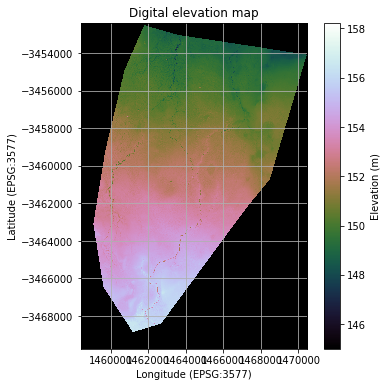

In [5]:
plt.figure(figsize=[6,6])
plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1, vmin=145)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude (EPSG:3577)');
plt.ylabel('Latitude (EPSG:3577)');

### Smooth the DEM and resolve a drainage network

<img align='right' src="./InputData/Nobreetal2011_HANDModelDiagramPits.JPG" style="width: 300px;"/>

Since our DEM is so flat, we need to do some smoothing of the DEM so that we can apply a flow model over the top of it. This involves removing any depressions where the flow dead ends as in the image to the top right, clipped from Figure 1 from [Nobre et al. 2011](http://www.sciencedirect.com/science/article/pii/S0022169411002599), and resolving a drainage network across flat regions, as in the image to the bottom right, Figure 3 from [Barnes et al. 2014](https://arxiv.org/abs/1511.04433).

To smooth the DEM, we perform a couple of steps in the cells below:
1. `grid.fill_depressions` : This function uses the [`skimage.morphology.reconstruction`](scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.reconstruction) erode method <img align='right' src="./InputData/Barnesetal2014_ResolveFlats.JPG" style="width: 300px;"/> to identify dead end depressions in the data, and then replace them with the values from the lowest neighbour. Depressions consist of regions (possibly groups of cells) for which every surrounding cell is at a higher elevation.
2. `grid.resolve_flats` : This function uses [`skimage.measure.label`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) to identify drainage networks within the DEM, then uses the method outlined in [Barnes et al. 2014](https://arxiv.org/abs/1511.04433) to exagerate the relief in the DEM to resolve a drainage network over areas with very low relief. 

In [6]:
# Fill dead end depressions
grid.fill_depressions(data='dem', out_name='nopits_dem')

In [7]:
# Inflate the DEM to resolve the drainage network over flat terrain
grid.resolve_flats(data='nopits_dem', out_name='inflated_dem')

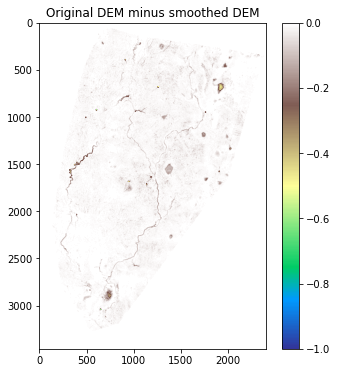

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow((grid.dem - grid.inflated_dem), cmap='terrain', interpolation='bilinear', vmin=-1)
plt.colorbar();
plt.title('Original DEM minus smoothed DEM');

### Compute flow direction based on corrected DEM

Now that we have a hydrologically resolved DEM, we want to calculate flow across the DEM. We do this using these two functions:
1. `grid.flowdir` : this function determines flow direction by finding the lowest cell in each nine x nine moving box.
2. `grid.accumulation` : this function calculates the number of upstream grid cells that drain into each cell. This is used to determine where streams are located.

In [9]:
# Calculate flow direction
grid.flowdir(data='inflated_dem', out_name='dir')
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc')

<a id='HAND'></a>
### Calculate height above nearest drainage (HAND)

Now that we have all the pieces we need, we can calculate the height above nearest drainage. 
The `HAND` terrain model [Nobre et al. 2011](http://www.sciencedirect.com/science/article/pii/S0022169411002599) calculates the height of each pixel relative to the nearest drainage point, thereby providing an indicator of the depth of water required to inundate each pixel. 

<img src="./InputData/Nobreetal2011_HANDModelDiagram.JPG" style="width: 500px;"/>

The diagram above from [Nobre et al. 2011](http://www.sciencedirect.com/science/article/pii/S0022169411002599) shows the process for calculating HAND. 
1. Figure a shows the drainage network calculated from a DEM. You can see that five cells have been coloured blue, and these represent the channel initiation and subsequent stream network, as they have more than *x* cells draining into them (you need to set *x* yourself, he it is set to 10). 
2. Figure b then associates each grid cell with one of these nodes to produce a nearest drainage map; e.g. all the light coloured '5's represent all the grid cells that drain into the dark '5' node. 
3. This nearest drainage map is then compared against the original DEM values (figure c). 
4. Finally, the HAND is calculated by subtracting the node height from each grid cell draining into it; e.g. the purple '36' in the top left corner is draining into the '33' dark purple node. 36 - 33 = 3, therefore the HAND is 3m for that cell.

The command in the cell below uses a `drainage mask` to determine the locations of significant streams that are used as the zero value in calculating HAND. The drainage mask applied below is `grid.acc > accumulation_threshold`. The `accumulation_threshold` determines how many LiDAR grid cells need to drain into a cell for it to be considered a significant drainage. These significant drainages will all be set to elevation = 0, and all remaining grid cells will be tagged with a relative elevation, according to their closest significant drainage. 

If you set the `accumulation_threshold` to be low, then small streams will be set to zero, resulting in more zero values across your scene, and decreasing the overall relative relief of catchments across the DEM. 
If you set this value to be high, then it generates very large catchments, and calculates relatively higher HAND values (as more cells are further from the drainage point). 

The `accumulation_threshold` is set in the [analysis parameters](#analysisparams) above.

In [10]:
grid.compute_hand('dir', 'inflated_dem', grid.acc > accumulation_threshold, 'hand')

Plot it to see how it looks.

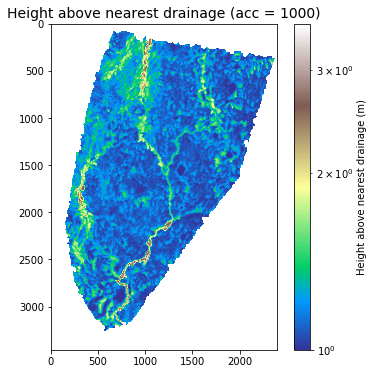

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(grid.hand + 1, zorder=1, cmap='terrain', interpolation='bilinear',
           norm=colors.LogNorm(vmin=1, vmax=np.nanmax(grid.hand)))
plt.colorbar(label='Height above nearest drainage (m)');
plt.title(f'Height above nearest drainage (acc = {accumulation_threshold})', size=14);

We can see the impact of the `accumulation_threshold` on the distribution of relative HAND heights by plotting them as a histogram. 

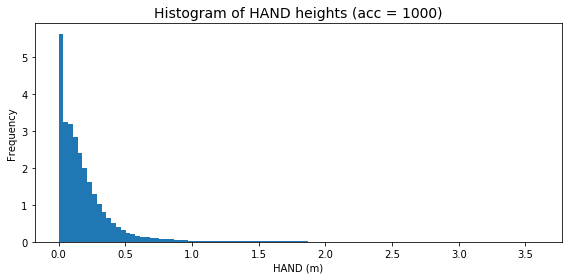

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
h = plt.hist(grid.hand[~np.isnan(grid.hand)], bins=100, density=True)
plt.title(f'Histogram of HAND heights (acc = {accumulation_threshold})', size=14)
plt.ylabel('Frequency')
plt.xlabel('HAND (m)')
plt.tight_layout()

If you want to write out any of these outputs to GeoTiff, use this command:

```
grid.to_raster('varname','filename.tif', dtype='int32')
```

### Convert all our grid objects back into xarray

This will make them compatible with the rest of the code, and save us doing conversions later on.

In [13]:
# Grab the HAND data and convert to a data array
LiDARds = xr.DataArray(grid.hand, dims=("y", "x"), coords=({'y':grid.grid_indices()[0], 'x':grid.grid_indices()[1]}))
# Convert our array to a dataset so we can add in the other variables we want to keep
LiDARds = LiDARds.to_dataset(name = 'HAND')
LiDARds.attrs['affine'] = grid.affine

# Let's grab the raw DEM data
DEM = xr.DataArray(grid.dem, dims=("y", "x"), coords=({'y':grid.grid_indices()[0], 'x':grid.grid_indices()[1]}))
# Replace missing values with nan
DEM = DEM.where(DEM!=grid.nodata)
# Add it back into our dataset
LiDARds['DEM'] = DEM

# And the inflated/corrected DEM
DEMCorr = xr.DataArray(grid.inflated_dem, dims=("y", "x"), coords=({'y':grid.grid_indices()[0], 'x':grid.grid_indices()[1]}))
# Replace missing values with nan
DEMCorr = DEMCorr.where(DEMCorr!=grid.nodata)
# Add it back into our dataset
LiDARds['DEMCorr'] = DEMCorr

# And the flow direction
DEMDir = xr.DataArray(grid.dir, dims=("y", "x"), coords=({'y':grid.grid_indices()[0], 'x':grid.grid_indices()[1]}))
# Add it back into our dataset
LiDARds['DEMDir'] = DEMDir

# And the flow accumulation
DEMAcc = xr.DataArray(grid.acc, dims=("y", "x"), coords=({'y':grid.grid_indices()[0], 'x':grid.grid_indices()[1]}))
# Add it back into our dataset
LiDARds['DEMAcc'] = DEMAcc

## 2. Load in and process the vegetation communities shapefile

We want to be able to relate water depth within the wetlands to vegetation communities, so we can get an understanding of which vegetation types are benefiting from water at any point in time.

For the Macquarie Marshes, we used data from the [NSW government](https://datasets.seed.nsw.gov.au/dataset/macquarie-marshes-vegetation1991-2008-vis_id-3920ff230/resource/3f102578-05ba-4a59-854d-fddd9ab27f53).

As with the lidar data, we need to reproject it to `EPSG:3577` so it's in the same projection as the native DEA satellite data. This reprojection step only needs to be done once since it saves out the new reprojected file. The code we used for this step is in the cell below.

In [14]:
VegComm = gpd.read_file(VegShapeFile) 

### Clip the vegetation shapefile to the extent of the LiDAR data
The vegetation community shapefile covers a much larger geographical extent than the LiDAR data, which is provided in small tiles due to its size. We need to clip down the veg data so we can just deal with the veg data that covers the LiDAR data extent.

#### Create a mask the same size as the LiDAR data

In [15]:
# Make a boolean mask for data/nan
rasterMask = ~np.isnan(LiDARds.DEM)
# Convert the raster to polygons 
# We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
LiDARPolygonMask = rasterio.features.shapes(rasterMask.data.astype('float32'), 
                                mask=rasterMask.data.astype('float32') == 1,
                                transform = grid.affine)
# The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
# not the value of each polygon (which here is just 1 for everything)
LiDARPolygonMaskbreaktuple = (a for a, b in LiDARPolygonMask)
LiDARPolygonMaskGP = gpd.GeoDataFrame(list(LiDARPolygonMaskbreaktuple), crs='EPSG:3577')
LiDARPolygonMaskGP['geometry'] = None
for ix, poly in LiDARPolygonMaskGP.iterrows():
    poly['geometry'] = shape(poly)
LiDARPolygonMaskGP = LiDARPolygonMaskGP.drop(columns=['type', 'coordinates'])

### Now clip the shapefile with the extents of the mask

In [16]:
ClippedVeg = gpd.clip(VegComm, LiDARPolygonMaskGP)

/usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


### And plot it to make sure it looks reasonable

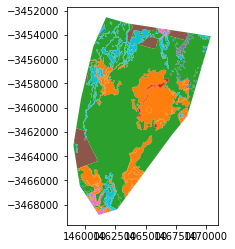

In [17]:
ClippedVeg.plot(column = VegShapeFileVegNameColumn);

## Assign a random numerical ID for each vegetation species
This is so we can burn it into the raster we create in the next step. 

If each vegetation community already has a numerical ID, set this parameter in `VegShapeFileVegNameUIDColumn` above. If it is set to `None` - i.e. doesn't already exist, we will generate one here.

In [18]:
if VegShapeFileVegNameUIDColumn:
    # if it already exists, copy it to 'RandomUID'
    ClippedVeg['RandomUID'] = ClippedVeg[VegShapeFileVegNameUIDColumn]
else:
    # else use groupby and ngroup to make one
    ClippedVeg['RandomUID'] = ClippedVeg.groupby(VegShapeFileVegNameColumn).ngroup()

# Grab all the unique ID numbers
unique_combinations = ClippedVeg[['RandomUID', VegShapeFileVegNameColumn]].drop_duplicates()
# Create a dict to map between the number and the species name string
SpeciesDict = dict(zip(unique_combinations.RandomUID, unique_combinations.Species_1))

## Rasterize the vegetation shapefile

We would like to have the vegetation communities and the LiDAR DEM both on the same grid (so we don't have to keep comparing raster and vector file formats). 
To do this we will use the random veg ID and make this the value of the raster file at that location. 

In [19]:
# Grab just the geometry and the numerical ID from the ClippedVeg shapefile
# (we don't need any of the other information)
shapes = zip(ClippedVeg['geometry'], ClippedVeg['RandomUID'])
# Grab the spatial information from the LiDAR data so we can project to the same raster grid
transform = LiDARds.attrs['affine']
y, x = LiDARds.DEM.values.shape

# Now convert the polgons into a numpy array
RasterVeg = rasterio.features.rasterize(shapes=shapes,
                                        out_shape=(y, x),
                                        all_touched=False,
                                        fill=np.nan,
                                        transform=transform)

# Convert result to a xarray.DataArray using coords etc from the LiDAR data
RasterVeg = xr.DataArray(RasterVeg,
                         coords=[LiDARds.y, LiDARds.x],
                         dims=['y', 'x'],
                         name='veg_randomUID',
                         attrs=LiDARds.attrs)

# Convert to xarray dataset to assist with writing to GeoTIFF
RasterVeg = RasterVeg.to_dataset()
# Copy over the atributes
RasterVeg.attrs = LiDARds.attrs

### Combine the LiDAR DEM and the rasterized vegetation data

This way we have one dataframe with both a DEM height, and a vegetation community.

In [20]:
CombineLiDARVeg = RasterVeg.merge(LiDARds)

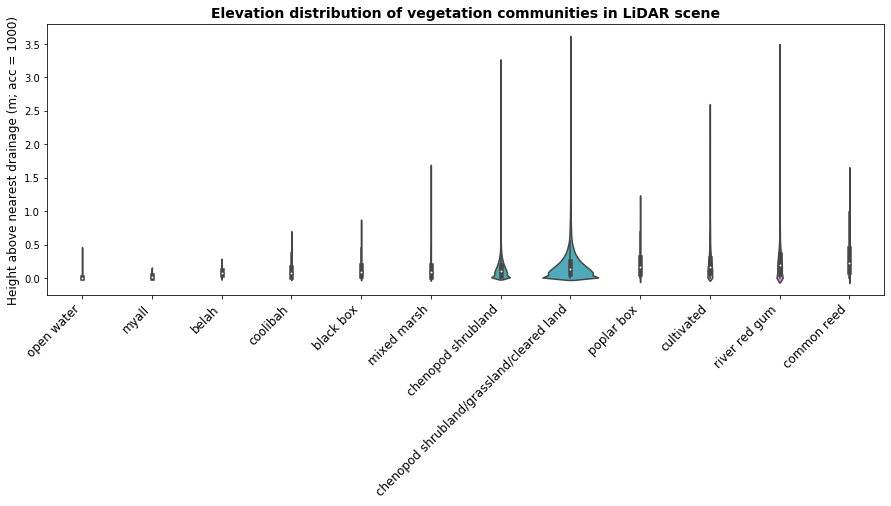

In [21]:
# Sort our results by the median HAND for each veg category
MedianHAND = CombineLiDARVeg.HAND.groupby(CombineLiDARVeg['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    XTickNames.append(VegName)

fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=CombineLiDARVeg['veg_randomUID'].values.flatten(), y=CombineLiDARVeg['HAND'].values.flatten(), 
                    order=myorder, scale='count')
ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.ylabel(f'Height above nearest drainage (m; acc = {accumulation_threshold})', fontsize = 12);
plt.title('Elevation distribution of vegetation communities in LiDAR scene', fontsize = 14, fontweight = 'bold');

## 3. Load in and process satellite observations

### Load in some satellite data

In [22]:
# Get spatial extent bounds from dimensions of LiDAR data
ymin = grid.extent[2]
ymax = grid.extent[3]
xmin = grid.extent[0]
xmax = grid.extent[1]

query = {'x': (xmin, xmax),
         'y': (ymax, ymin),
         'crs': grid.crs.srs,
         'measurements': ['nbart_red', 'nbart_blue', 'nbart_green', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'resolution': (-25, 25),
         'output_crs': grid.crs.srs,
         'resampling': {'fmask': 'nearest', '*': 'average'}, 
        }

# Load in only satellite observations with less than minimum_cloudfree_perc clear pixels
satellite_ds = load_ard(dc=dc, 
                        products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
                        min_gooddata=minimum_cloudfree_perc,
                        **query)

Loading ga_ls5t_ard_3 data
    Filtering to 527 out of 701 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    Filtering to 537 out of 772 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Filtering to 200 out of 267 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 1264 observations 


### Mask the data that have been returned using the spatial footprint of LiDAR

In [23]:
SatelliteMask = rasterio.features.geometry_mask(LiDARPolygonMaskGP.iloc[0],
                                      out_shape=(len(satellite_ds.y), len(satellite_ds.x)),
                                      transform=satellite_ds.geobox.transform,
                                      invert=True)
SatelliteMask = xr.DataArray(SatelliteMask, dims=("y", "x"))

In [24]:
SatelliteDSmasked = satellite_ds.where(SatelliteMask == True)

### Calculate wetness index

Here we use the Tasselled Cap Wetness Index from [Crist 1985](https://doi.org/10.1016/0034-4257(85)90102-6).

This index can be used to identify water and wet vegetation, using the thresholds below. Note that these are rough, and may need to be modified depending on the area in which you are applying this index. 

* <-1200 -- becoming progressively less wet. 
    * The TCW is a continuous index. 
* -1200 -- ‘wettish’
    * Useful for identifying springs or boggy ground, may capture wet vegetation 
* -600 -- ‘wet’ 
    * Useful for identifying a combination of open water and wet vegetation 
* **-350 -- ‘wet according to the Mac Marshes project’** 
    * **A rough threshold set for the tasselled cap wetness for the Macquarie Marshes, to match up with work by Thomas et al. (2015) on mapping the inundation associated with flow events, was -350 for visibly (from a helicopter) inundated vegetation and water for one event.**
* 0 –- useful threshold for identifying areas of open water. 
    * Values of 0 and above generally correspond to Water Observations from Space (WOfS) areas classified as open water. 

In [25]:
# Compute Tasselled Cap Wetness Index (TCW)
SatelliteIndices = calculate_indices(SatelliteDSmasked, 
                                 index='TCW', 
                                 collection='ga_ls_3',
                                 normalise=False
                                )

../../Scripts/dea_bandindices.py:263: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


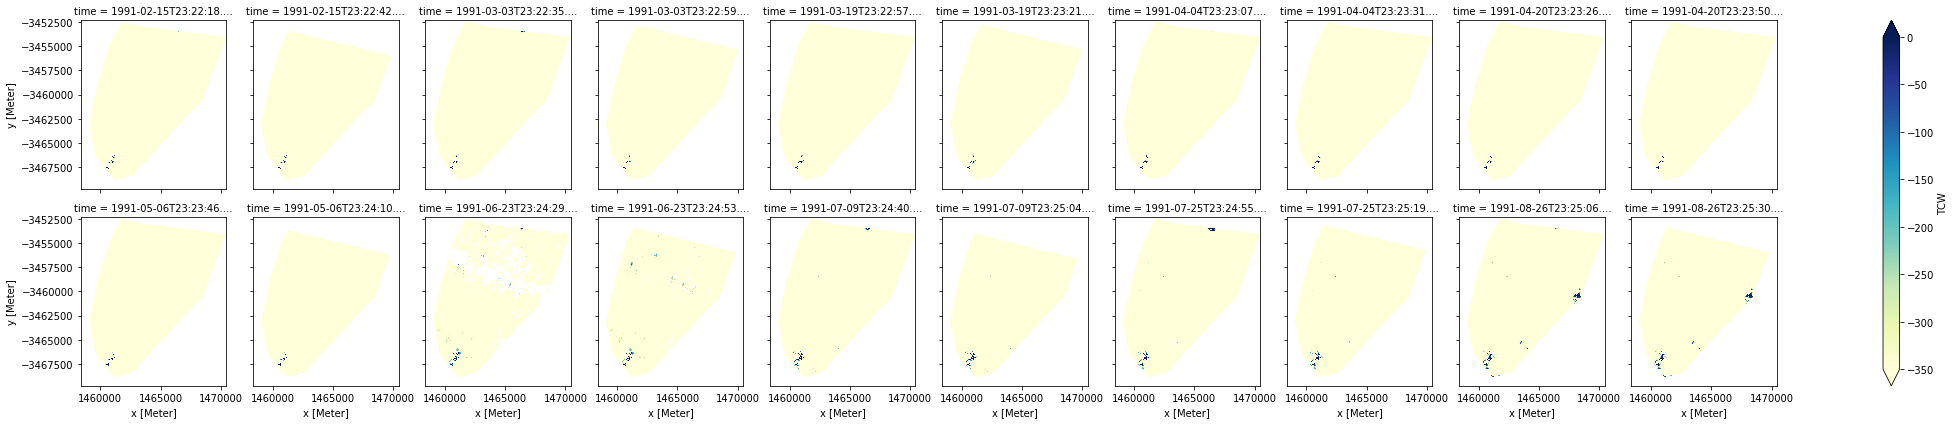

In [26]:
# Preview results for the first 30 observations
SatelliteIndices.TCW.isel(time=slice(90, 110)).plot.imshow(col='time',
                                                       col_wrap=10,
                                                       vmin=-350, 
                                                       vmax=0,
                                                       cmap='YlGnBu',
                                                       add_labels=False)

### Create a new variable of just the thresholded TCW

In [27]:
SatelliteIndices['wet'] = SatelliteIndices.TCW.where(SatelliteIndices.TCW>=-350)

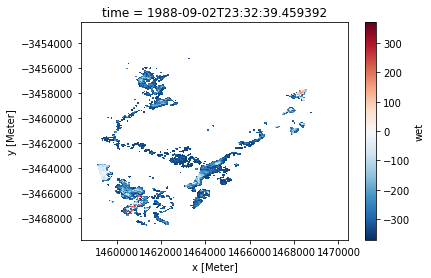

In [28]:
SatelliteIndices.wet.isel(time=30).plot()

### Plot some Landsat data over the top to show the scale of each dataset

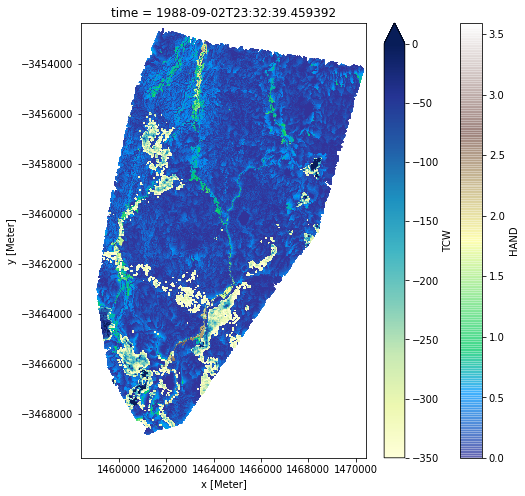

In [29]:
LiDARds.HAND.plot(figsize=(8, 8), cmap = 'terrain', alpha=0.5);
SatelliteIndices.TCW.where(SatelliteIndices.TCW>=-350).isel(time=30).plot(vmin=-350, vmax=0, cmap='YlGnBu');

## Resample the LiDAR to the same grid as the satellite data

Originally I tried to resample the satellite data to the LiDAR grid, but the data volume was too large and kept killing the kernal. For now, the workflow downsamples the LiDAR to the Landsat resolution instead.

In [30]:
LiDARonSatellitegrid = CombineLiDARVeg.interp(x=SatelliteIndices["x"], y=SatelliteIndices["y"], method='nearest')

## Grab just the LiDAR heights for each wet pixel

In [31]:
SatelliteIndices['justwetHAND'] = LiDARonSatellitegrid.HAND.where(~np.isnan(SatelliteIndices['wet']))

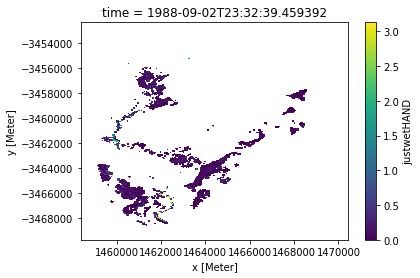

In [32]:
SatelliteIndices['justwetHAND'].isel(time=30).plot()

### Plot the relationship between 'wet' pixels and LiDAR height

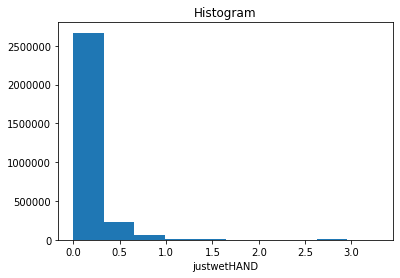

In [33]:
SatelliteIndices['justwetHAND'].expand_dims().plot();

## Now pull EVERYTHING together

In [34]:
AllDataCombined = SatelliteIndices.merge(LiDARonSatellitegrid)

In [35]:
AllDataCombined

<xarray.Dataset>
Dimensions:        (time: 1264, x: 483, y: 696)
Coordinates:
  * x              (x) float64 1.458e+06 1.458e+06 ... 1.47e+06 1.47e+06
  * y              (y) float64 -3.452e+06 -3.452e+06 ... -3.47e+06 -3.47e+06
  * time           (time) datetime64[ns] 1987-05-27T23:25:36.184280 ... 2019-08-15T23:49:02.469302
Data variables:
    nbart_red      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_1   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_2   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TCW            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    wet            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    justwetHAND    (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    veg_randomUID  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    HAND           (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    DEM            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    DEMCorr        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    DEMDir         (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    DEMAcc         (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0 +y_0...

### And start playing with it

We want to map the total number of wet pixels per timestep to the vegetation categories so we can see what proportion of each vegetation category is currently 'wet'.

In [125]:
# Count the number of pixels mapped to each vegetation type
AllVegTypeCounts = pd.value_counts(AllDataCombined['veg_randomUID'].values.flatten()).to_dict()
AllVegTypeCounts = {int(key):AllVegTypeCounts[key] for key in AllVegTypeCounts}

VegNameCounts = {SpeciesDict[k]: v for k,v in AllVegTypeCounts.items()}

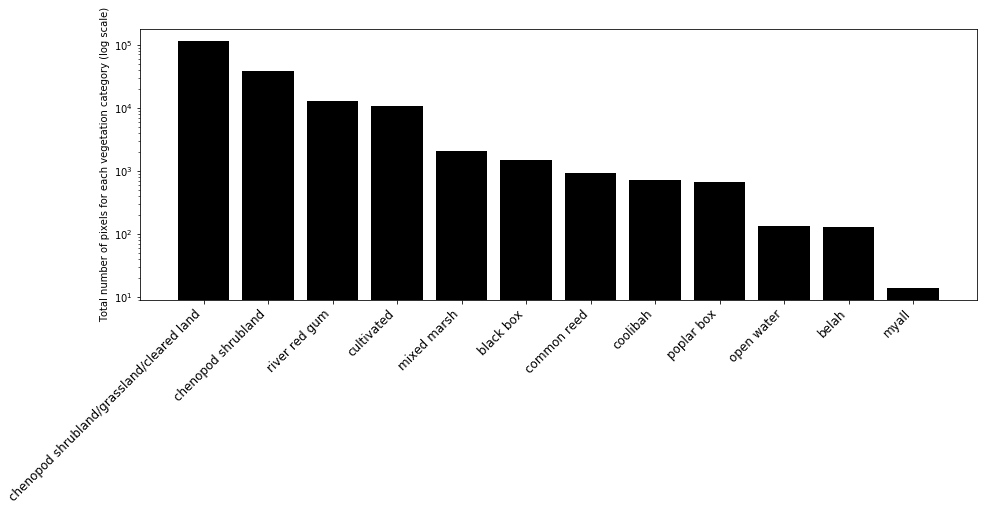

In [126]:
fig, ax = plt.subplots(figsize=[15,5])
plt.bar(VegNameCounts.keys(), VegNameCounts.values(), color = 'k')
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right', fontsize=12);
plt.ylabel('Total number of pixels for each vegetation category (log scale)');

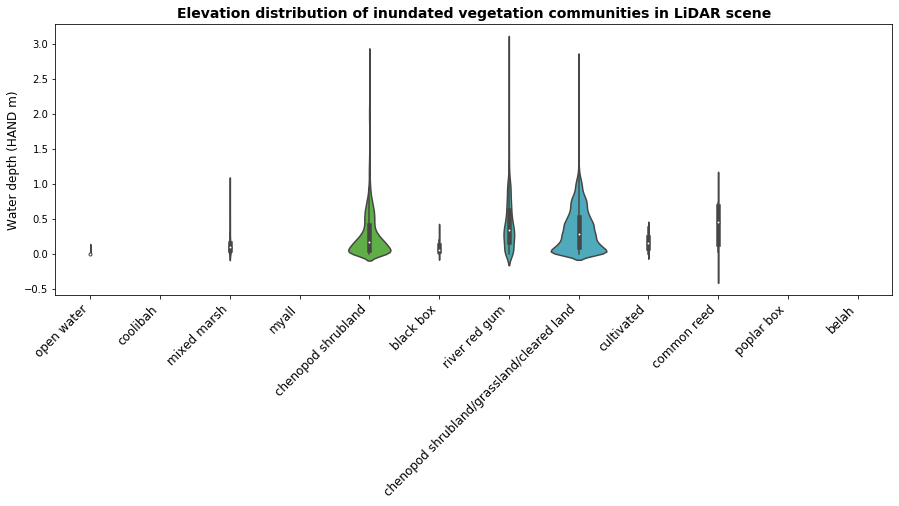

In [129]:
fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                    y=AllDataCombined['justwetHAND'].isel(time=36).values.flatten(), 
                    order=myorder, scale='count')
ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.ylabel('Water depth (HAND m)', fontsize = 12);
plt.title('Elevation distribution of inundated vegetation communities in LiDAR scene', fontsize = 14, fontweight = 'bold');

In [304]:
singleBandtiff = AllDataCombined[['TCW']].isel(time=37)

# Write GeoTIFF to a location
write_geotiff('WetTimesliceMacMarshes.tif', singleBandtiff)

### Count the number of wet observations for each pixel, and plot against HAND

We would hope that the higher pixels are inundated less frequently...

In [36]:
AllDataCombined['WetFreq'] = AllDataCombined.wet.count(dim='time')

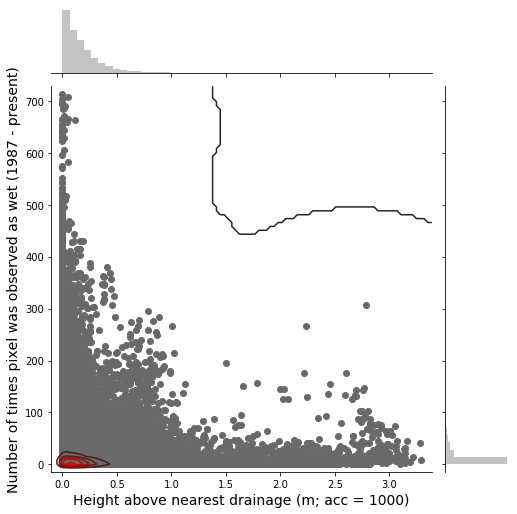

In [41]:
h = (sns.jointplot(x=AllDataCombined.HAND.values.flatten(), 
                   y=AllDataCombined.WetFreq.values.flatten(), 
                   kind='scatter', height=7,color='dimgrey').plot_joint(sns.kdeplot, 
                                                         zorder=1,
                                                         n_levels=5, color='r'));
h.set_axis_labels(f'Height above nearest drainage (m; acc = {accumulation_threshold})', 
                  'Number of times pixel was observed as wet (1987 - present)', fontsize=14);